#Load library and data

In [1]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DA VEF 2022/Final project/Raw Data/CustomerSegmentationData.csv', header = None)

In [4]:
df.columns = ['customer_id','order_id','value','date']
df.head()

,customer_id,order_id,value,date
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,7219,2017-09-13 08:59:02.0000000
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,25983,2017-04-26 10:53:06.0000000
2,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,21687,2018-01-14 14:33:31.0000000
3,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2578,2018-08-08 10:00:35.0000000
4,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,21804,2017-02-04 13:57:51.0000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110197 entries, 0 to 110196
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  110197 non-null  object
 1   order_id     110197 non-null  object
 2   value        110197 non-null  int64 
 3   date         110197 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


#Preprocessing

## Missing data 

In [6]:
df_na = (df.isnull().sum() / len(df)) * 100 # percentage of missing entries

df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head(20)

,miss_rate


##Convert type

In [7]:
df['date'] = pd.to_datetime(df['date']).dt.date

In [8]:
df.describe()

,value
count,110197.000000
mean,13992.916096
std,18931.915123
min,608.000000
25%,5518.000000
50%,9213.000000
75%,15751.000000
max,692931.000000


In [9]:
df.describe(include = 'object')

,customer_id,order_id,date
count,110197,110197,110197
unique,93358,96478,612
top,c8460e4251689ba205045f3ea17884a1,8272b63d03f5f79c56e9e4120aec44ef,2017-11-24
freq,24,21,1345


##RFM 

In [10]:
rfm = df.groupby('customer_id').agg({'order_id':'nunique','date':['min','max'],'value':'sum'}).reset_index()
rfm.columns = ["customer_id","frequency","first_order_date","last_order_date","monetary"]

In [11]:
last_date = rfm["last_order_date"].max()
rfm["recency"] = [(last_date- x).days for x in rfm["last_order_date"]]

In [12]:
rfm["recency"].sort_values()

33812      0
46739      0
4587       0
13433      0
66821      0
        ... 
35810    695
6221     695
42237    695
51400    695
47882    713
Name: recency, Length: 93358, dtype: int64

In [13]:
rfm.head()

,customer_id,frequency,first_order_date,last_order_date,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,2018-05-10,14190,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,2018-05-07,2719,114
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,2017-03-10,8622,537
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,2017-10-12,4362,321
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,2017-11-14,19689,288


#RFM score

In [14]:
rfm.shape

(93358, 6)

the number of customer is less than 100k so I will label rfm from 1 to 4.

In [15]:
rfm["RecencyScore"] = pd.cut(rfm["recency"], 
                                       bins=[-1, 
                                             np.percentile(rfm["recency"], 25), 
                                             np.percentile(rfm["recency"], 50), 
                                             np.percentile(rfm["recency"], 75), 
                                             rfm["recency"].max()], 
                                       labels=[4,3,2,1]).astype("int")

In [16]:
rfm["MonetaryScore"] = pd.cut(rfm["monetary"], 
                                       bins=[-1, 
                                             np.percentile(rfm["monetary"], 25), 
                                             np.percentile(rfm["monetary"], 50), 
                                             np.percentile(rfm["monetary"], 75), 
                                             rfm["monetary"].max()], 
                                       labels=[4,3,2,1]).astype("int")

In [17]:
rfm.head()

,customer_id,frequency,first_order_date,last_order_date,monetary,recency,RecencyScore,MonetaryScore
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,2018-05-10,14190,111,4,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,2018-05-07,2719,114,4,4
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,2017-03-10,8622,537,1,3
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,2017-10-12,4362,321,2,4
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,2017-11-14,19689,288,2,1


In [18]:
rfm['frequency'].describe()

count    93358.000000
mean         1.033420
std          0.209097
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: frequency, dtype: float64

In [19]:
rfm[rfm['frequency'] >1]['customer_id'].count()/rfm[rfm['frequency'] ==1]['customer_id'].count()

0.030930794968914606

In [20]:
#purchase more than 1 time
rfm['morethan_1'] = rfm['frequency'] > 1

In [21]:
rfm

,customer_id,frequency,first_order_date,last_order_date,monetary,recency,RecencyScore,MonetaryScore,morethan_1
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,2018-05-10,14190,111,4,2,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,2018-05-07,2719,114,4,4,False
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,2017-03-10,8622,537,1,3,False
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,2017-10-12,4362,321,2,4,False
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,2017-11-14,19689,288,2,1,False
...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08,2017-06-08,206742,447,1,1,False
93354,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10,2017-12-10,8458,262,2,3,False
93355,ffff371b4d645b6ecea244b27531430a,1,2017-02-07,2017-02-07,11246,568,1,2,False
93356,ffff5962728ec6157033ef9805bacc48,1,2018-05-02,2018-05-02,13369,119,3,2,False


In [22]:
rfm['RFM_Group'] = rfm['morethan_1'].astype('int').map(str) + rfm['RecencyScore'].map(str) + rfm['MonetaryScore'].map(str)
rfm['RFM_Score'] = rfm['morethan_1'].astype('int') + rfm['RecencyScore'] + rfm['MonetaryScore']
rfm['RM_segment'] = rfm['RecencyScore'].map(str) + rfm['MonetaryScore'].map(str)
rfm

,customer_id,frequency,first_order_date,last_order_date,monetary,recency,RecencyScore,MonetaryScore,morethan_1,RFM_Group,RFM_Score,RM_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,2018-05-10,14190,111,4,2,False,042,6,42
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,2018-05-07,2719,114,4,4,False,044,8,44
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,2017-03-10,8622,537,1,3,False,013,4,13
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,2017-10-12,4362,321,2,4,False,024,6,24
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,2017-11-14,19689,288,2,1,False,021,3,21
...,...,...,...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08,2017-06-08,206742,447,1,1,False,011,2,11
93354,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10,2017-12-10,8458,262,2,3,False,023,5,23
93355,ffff371b4d645b6ecea244b27531430a,1,2017-02-07,2017-02-07,11246,568,1,2,False,012,3,12
93356,ffff5962728ec6157033ef9805bacc48,1,2018-05-02,2018-05-02,13369,119,3,2,False,032,5,32


##Loyal and Onetime_Customer

In [23]:
F_map = {
    r'1[1-4][1-4]':'Loyal',
    r'0[1-4][1-4]':'Onetime_Customer'
}
rfm['F_Group'] = rfm['RFM_Group'].replace(F_map, regex=True)
rfm

,customer_id,frequency,first_order_date,last_order_date,monetary,recency,RecencyScore,MonetaryScore,morethan_1,RFM_Group,RFM_Score,RM_segment,F_Group
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,2018-05-10,14190,111,4,2,False,042,6,42,Onetime_Customer
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,2018-05-07,2719,114,4,4,False,044,8,44,Onetime_Customer
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,2017-03-10,8622,537,1,3,False,013,4,13,Onetime_Customer
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,2017-10-12,4362,321,2,4,False,024,6,24,Onetime_Customer
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,2017-11-14,19689,288,2,1,False,021,3,21,Onetime_Customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08,2017-06-08,206742,447,1,1,False,011,2,11,Onetime_Customer
93354,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10,2017-12-10,8458,262,2,3,False,023,5,23,Onetime_Customer
93355,ffff371b4d645b6ecea244b27531430a,1,2017-02-07,2017-02-07,11246,568,1,2,False,012,3,12,Onetime_Customer
93356,ffff5962728ec6157033ef9805bacc48,1,2018-05-02,2018-05-02,13369,119,3,2,False,032,5,32,Onetime_Customer


In [24]:
RM_map = {
    r'4[3-4]':'Must_Focus',
    r'4[1-2]':'Promising',
    r'3[3-4]':'Need_Attention',
    r'3[1-2]': 'About to sleep',
    r'2[1-4]': 'Hibernating',
    r'1[1-4]':'Churn'
}
rfm['RM_group'] = rfm['RM_segment'].replace(RM_map, regex=True)
rfm

,customer_id,frequency,first_order_date,last_order_date,monetary,recency,RecencyScore,MonetaryScore,morethan_1,RFM_Group,RFM_Score,RM_segment,F_Group,RM_group
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,2018-05-10,14190,111,4,2,False,042,6,42,Onetime_Customer,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,2018-05-07,2719,114,4,4,False,044,8,44,Onetime_Customer,Must_Focus
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,2017-03-10,8622,537,1,3,False,013,4,13,Onetime_Customer,Churn
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,2017-10-12,4362,321,2,4,False,024,6,24,Onetime_Customer,Hibernating
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,2017-11-14,19689,288,2,1,False,021,3,21,Onetime_Customer,Hibernating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08,2017-06-08,206742,447,1,1,False,011,2,11,Onetime_Customer,Churn
93354,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10,2017-12-10,8458,262,2,3,False,023,5,23,Onetime_Customer,Hibernating
93355,ffff371b4d645b6ecea244b27531430a,1,2017-02-07,2017-02-07,11246,568,1,2,False,012,3,12,Onetime_Customer,Churn
93356,ffff5962728ec6157033ef9805bacc48,1,2018-05-02,2018-05-02,13369,119,3,2,False,032,5,32,Onetime_Customer,About to sleep


In [25]:
loyal = rfm[rfm['F_Group'] == 'Loyal']
onetime = rfm[rfm['F_Group'] == 'Onetime_Customer']

###Loyal

In [26]:
loyal_level = loyal.groupby('RM_group').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)

loyal_level

recency frequency monetary      
                  mean      mean     mean count
RM_group                                       
About to sleep   168.6       2.1  32702.8   671
Churn            439.5       2.1  29026.5   577
Hibernating      277.8       2.1  30971.0   681
Must_Focus        59.6       2.0   8267.4    89
Need_Attention   166.4       2.0   8153.9    81
Promising         58.4       2.2  35953.5   702

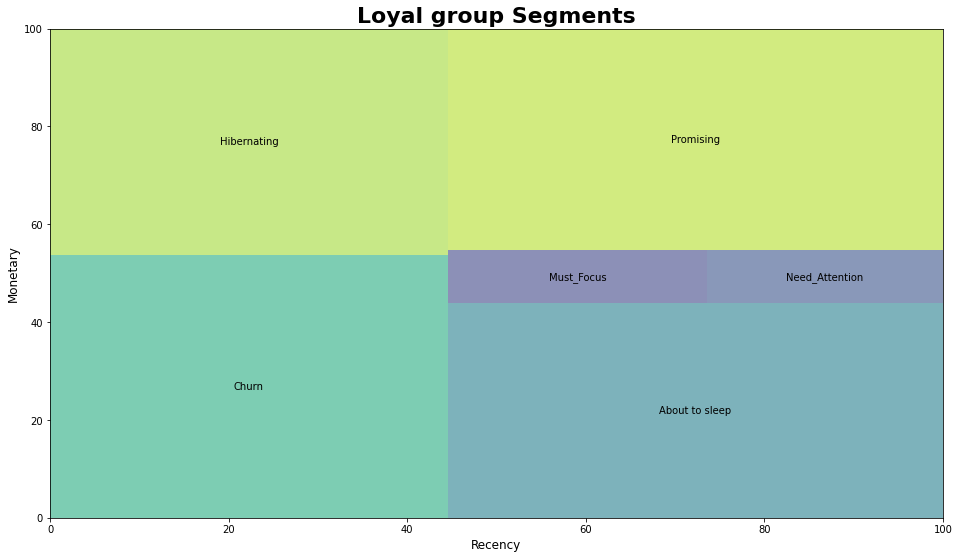

In [27]:
loyal_level.columns = ['Recencymean','Frequencymean', 'Monetarymean','Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=loyal_level['Count'], 
              label=['Churn','Hibernating','About to sleep','Must_Focus','Need_Attention','Promising'], alpha=.6 )
plt.title("Loyal group Segments",fontsize=22,fontweight="bold")
ax.set_xlabel('Recency',fontsize=12)
ax.set_ylabel('Monetary',fontsize=12)
plt.axis('on')
plt.show()

###Onetime Customer

In [28]:
onetime_level = onetime.groupby('RM_group').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)

onetime_level

recency frequency monetary       
                  mean      mean     mean  count
RM_group                                        
About to sleep   165.3       1.0  25640.9  11088
Churn            451.5       1.0  16094.1  22692
Hibernating      276.6       1.0  15863.9  22728
Must_Focus        56.4       1.0   6309.2  11376
Need_Attention   166.8       1.0   6292.0  11289
Promising         58.4       1.0  26588.8  11384

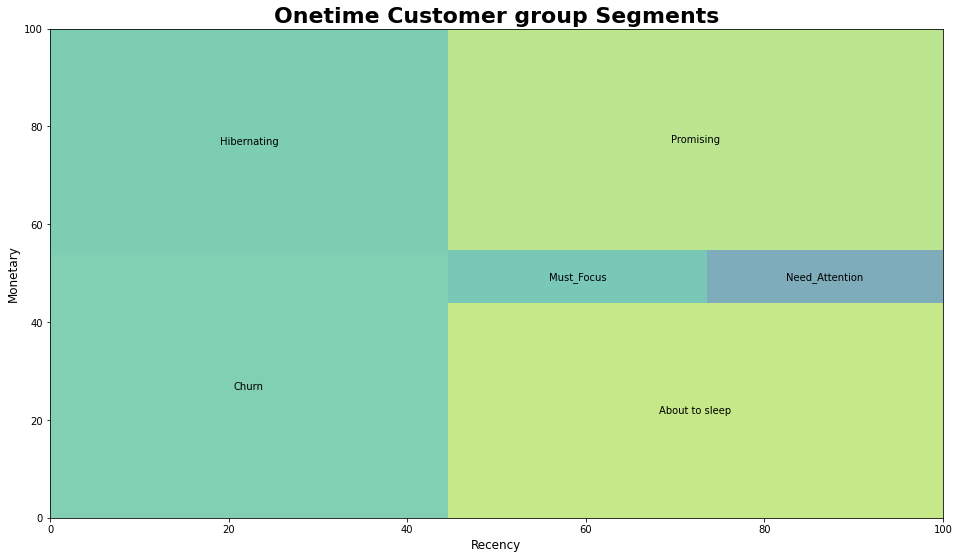

In [29]:
onetime_level.columns = ['Recencymean','Frequencymean', 'Monetarymean','Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=loyal_level['Count'], 
              label=['Churn','Hibernating','About to sleep','Must_Focus','Need_Attention','Promising'], alpha=.6 )
plt.title("Onetime Customer group Segments",fontsize=22,fontweight="bold")
ax.set_xlabel('Recency',fontsize=12)
ax.set_ylabel('Monetary',fontsize=12)
plt.axis('on')
plt.show()

#EDA

## Summary

In [30]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       93358 non-null  object
 1   frequency         93358 non-null  int64 
 2   first_order_date  93358 non-null  object
 3   last_order_date   93358 non-null  object
 4   monetary          93358 non-null  int64 
 5   recency           93358 non-null  int64 
 6   RecencyScore      93358 non-null  int64 
 7   MonetaryScore     93358 non-null  int64 
 8   morethan_1        93358 non-null  bool  
 9   RFM_Group         93358 non-null  object
 10  RFM_Score         93358 non-null  int64 
 11  RM_segment        93358 non-null  object
 12  F_Group           93358 non-null  object
 13  RM_group          93358 non-null  object
dtypes: bool(1), int64(6), object(7)
memory usage: 9.3+ MB


In [31]:
rfm.describe()

,frequency,monetary,recency,RecencyScore,MonetaryScore,RFM_Score
count,93358.000000,9.335800e+04,93358.000000,93358.000000,93358.000000,93358.000000
mean,1.033420,1.651682e+04,237.478877,2.503031,2.500161,5.033195
std,0.209097,2.262921e+04,152.595054,1.119386,1.118097,1.561059
min,1.000000,9.590000e+02,0.000000,1.000000,1.000000,2.000000
25%,1.000000,6.301000e+03,114.000000,2.000000,2.000000,4.000000
50%,1.000000,1.077800e+04,218.000000,3.000000,3.000000,5.000000
75%,1.000000,1.825100e+04,346.000000,4.000000,4.000000,6.000000
max,15.000000,1.366408e+06,713.000000,4.000000,4.000000,9.000000


In [32]:
rfm.describe(include = ['O'])

,customer_id,first_order_date,last_order_date,RFM_Group,RM_segment,F_Group,RM_group
count,93358,93358,93358,93358,93358,93358,93358
unique,93358,612,611,32,16,2,6
top,0000366f3b9a7992bf8c76cfdf3221e2,2017-11-24,2017-11-24,013,13,Onetime_Customer,Hibernating
freq,1,1114,1114,6004,6072,90557,23409


##Data distribution

Text(0.5, 1.0, 'Monetary')

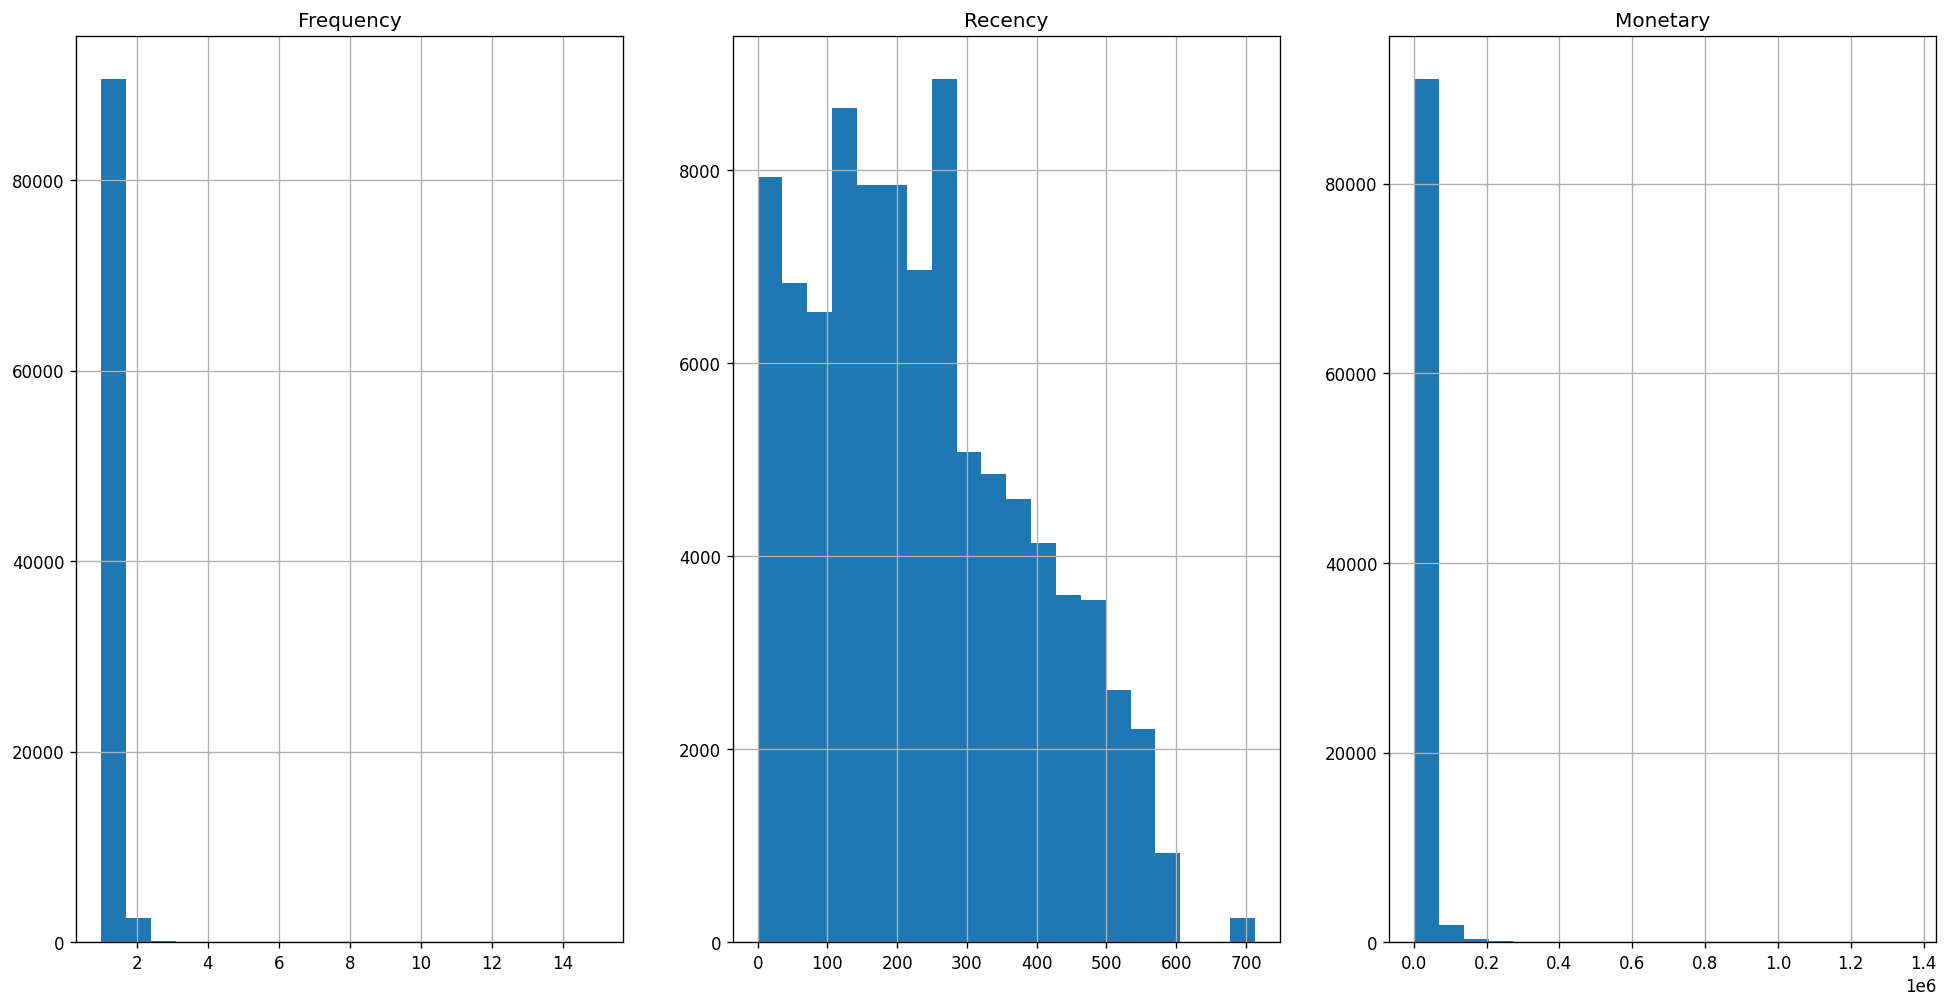

In [33]:
fig, ax0 = plt.subplots(nrows=1, ncols=3,figsize=(20,10),dpi=120)
rfm['frequency'].hist(bins= 20,ax = ax0[0])
rfm['recency'].hist(bins= 20,ax = ax0[1])
rfm['monetary'].hist(bins= 20,ax = ax0[2])

ax0[0].set_title('Frequency')
ax0[1].set_title('Recency')
ax0[2].set_title('Monetary')

Text(0.5, 1.0, 'Monetary')

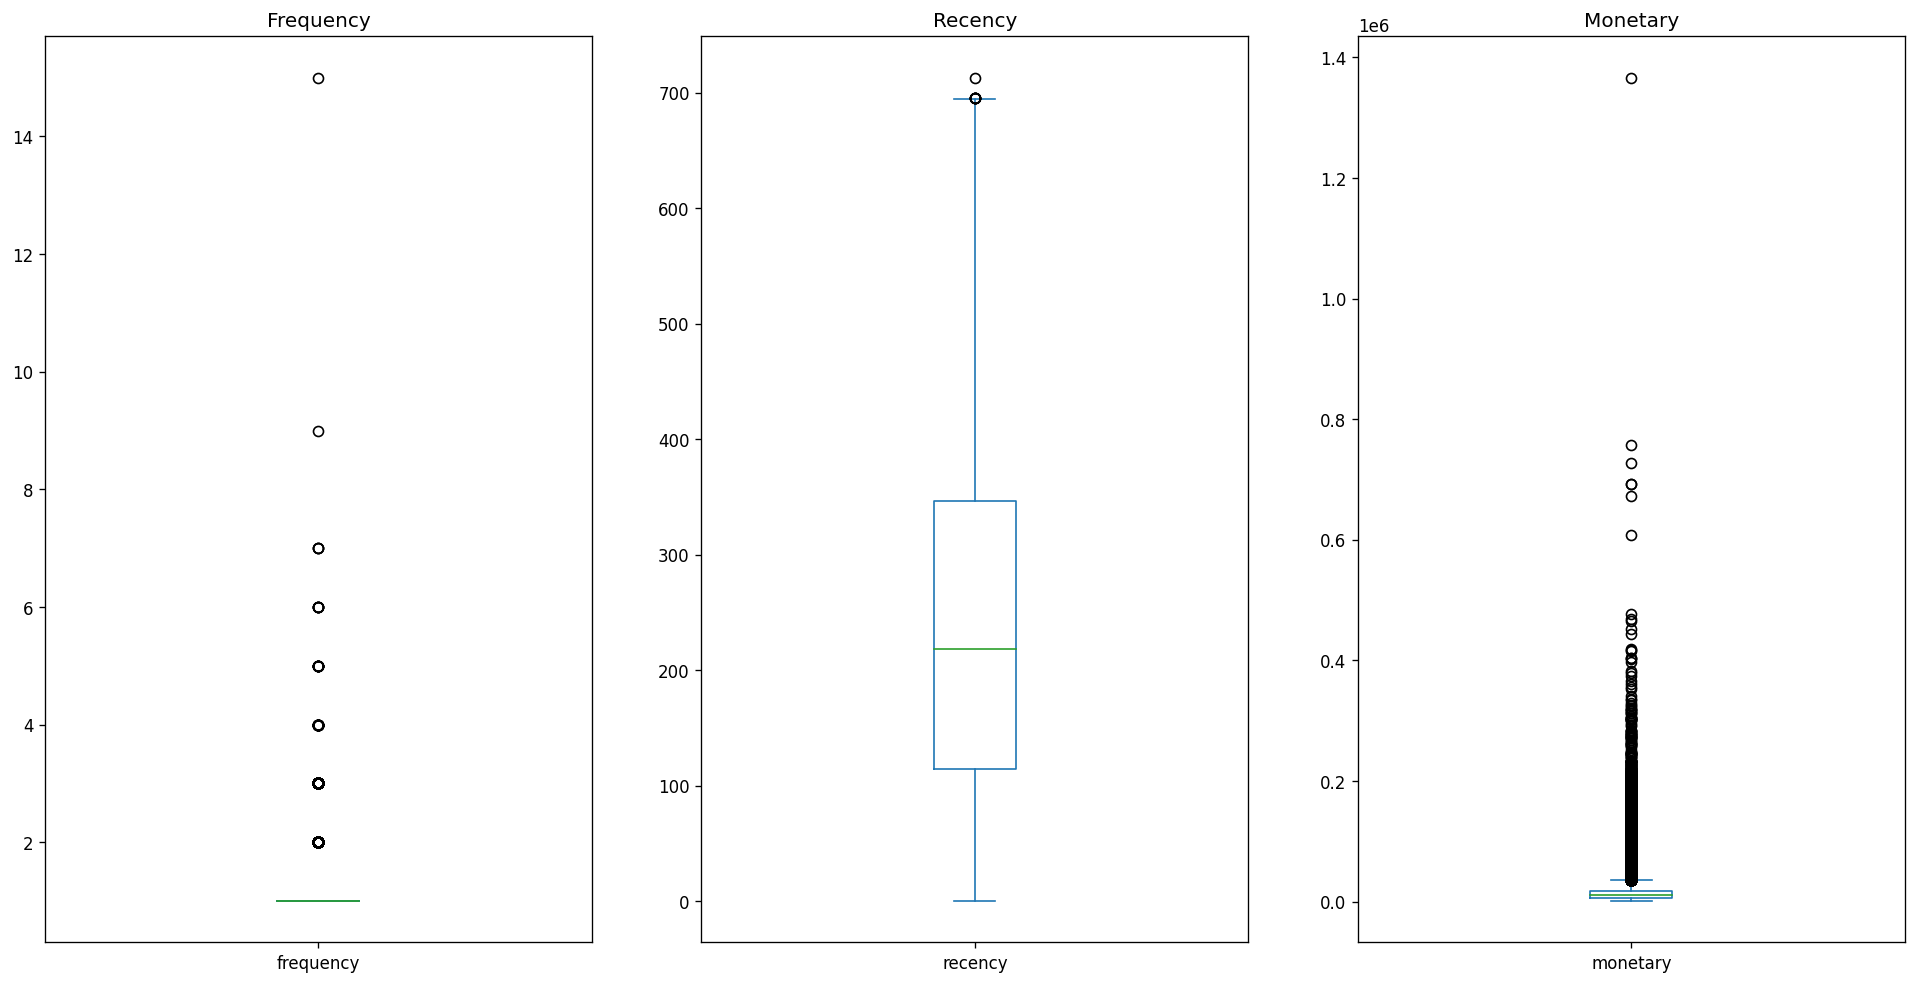

In [34]:
fig, ax1 = plt.subplots(nrows=1, ncols=3,figsize=(20,10),dpi=120)
rfm['frequency'].plot.box(ax = ax1[0])
rfm['recency'].plot.box(ax = ax1[1])
rfm['monetary'].plot.box(ax = ax1[2])

ax1[0].set_title('Frequency')
ax1[1].set_title('Recency')
ax1[2].set_title('Monetary')

([<matplotlib.patches.Wedge at 0x7f4d649b45d0>,
 [Text(1.095117255022391, 0.10352872911527285, '>1'),
  Text(-1.0951172507816769, -0.1035287739731439, '=1')],
 [Text(0.5973366845576678, 0.05647021588105791, '3.0%'),
  Text(-0.5973366822445509, -0.05647024034898758, '97.0%')])

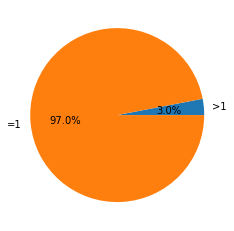

In [35]:
frequency = pd.DataFrame({'freq':['>1','=1'],'number':[rfm[rfm['frequency'] >1]['customer_id'].count(),rfm[rfm['frequency'] ==1]['customer_id'].count()]})
plt.pie(frequency['number'], labels = frequency['freq'],autopct='%1.1f%%')

Most customer only shop once

##K-optimal

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm

In [37]:
ks = list(range(2,11))
train = rfm[['frequency','recency','monetary']]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

In [38]:
wssd = [] 

for k in ks:
    model = KMeans(n_clusters=k).fit(train_scaled)
    wssd.append(model.inertia_ / len(train))


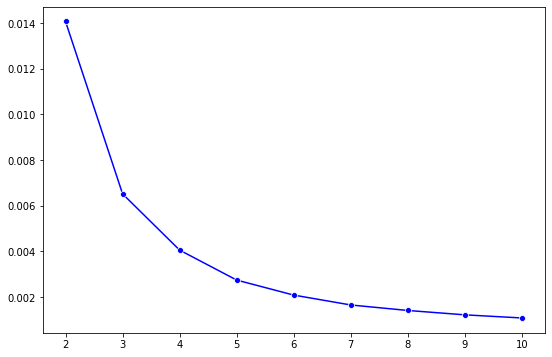

In [39]:
plt.figure(figsize=(9, 6))
ax = sns.lineplot(
    x=ks, y=wssd, color='blue',
    marker='o',
    label='WSSD', legend=None
)

ax.grid(False)


# Customer Segmentation

In [40]:
n_clusters = 4
model = KMeans(n_clusters=n_clusters).fit(train_scaled)
cluster_labels = model.predict(train_scaled)
rfm['cluster'] = cluster_labels
rfm.head()

,customer_id,frequency,first_order_date,last_order_date,monetary,recency,RecencyScore,MonetaryScore,morethan_1,RFM_Group,RFM_Score,RM_segment,F_Group,RM_group,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10,2018-05-10,14190,111,4,2,False,042,6,42,Onetime_Customer,Promising,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07,2018-05-07,2719,114,4,4,False,044,8,44,Onetime_Customer,Must_Focus,3
2,0000f46a3911fa3c0805444483337064,1,2017-03-10,2017-03-10,8622,537,1,3,False,013,4,13,Onetime_Customer,Churn,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12,2017-10-12,4362,321,2,4,False,024,6,24,Onetime_Customer,Hibernating,2
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14,2017-11-14,19689,288,2,1,False,021,3,21,Onetime_Customer,Hibernating,2


In [41]:
import plotly.express as px

fig = px.scatter_3d(rfm, x='recency', y='frequency', z='monetary',
              color='cluster')
fig.add_scatter3d(x=model.cluster_centers_[:,0], y=model.cluster_centers_[:,1], z=model.cluster_centers_[:,2])
fig.show()

# Post Analysis

In [42]:
rfm.groupby("cluster").agg({"cluster":"count",
                            "recency":["min",np.median,"mean","max"],
                            "frequency":["min",np.median,"mean","max"],
                            "monetary":["min",np.median,"mean","max"]})

cluster recency                         frequency                   \
          count     min median        mean  max       min median      mean   
cluster                                                                      
0         27093     123  183.0  183.428930  248         1    1.0  1.035323   
1         16553     399  475.0  483.372078  713         1    1.0  1.024890   
2         24301     249  307.0  313.831365  398         1    1.0  1.031768   
3         25411       0   62.0   61.911731  123         1    1.0  1.038527   

            monetary                                  
        max      min   median          mean      max  
cluster                                               
0         9     1336  10800.0  16130.072343   417526  
1         6     1228  10501.0  16343.071528   757163  
2         4     1007  10687.0  16594.832229  1366408  
3        15      959  11082.0  16967.747983   727488

In [43]:
rfm_scaled = rfm.copy()
rfm_scaled[['recency', 'frequency', 'monetary']] = train_scaled
rfm_melt = pd.melt(
    rfm_scaled.reset_index(),
    id_vars=['customer_id','cluster'],
    value_vars=['recency', 'frequency', 'monetary'],
    var_name='attribute',
    value_name='value')
rfm_melt.head()

,customer_id,cluster,attribute,value
0,0000366f3b9a7992bf8c76cfdf3221e2,3,recency,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3,recency,0.0
2,0000f46a3911fa3c0805444483337064,1,recency,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,2,recency,0.0
4,0004aac84e0df4da2b147fca70cf8255,2,recency,0.0


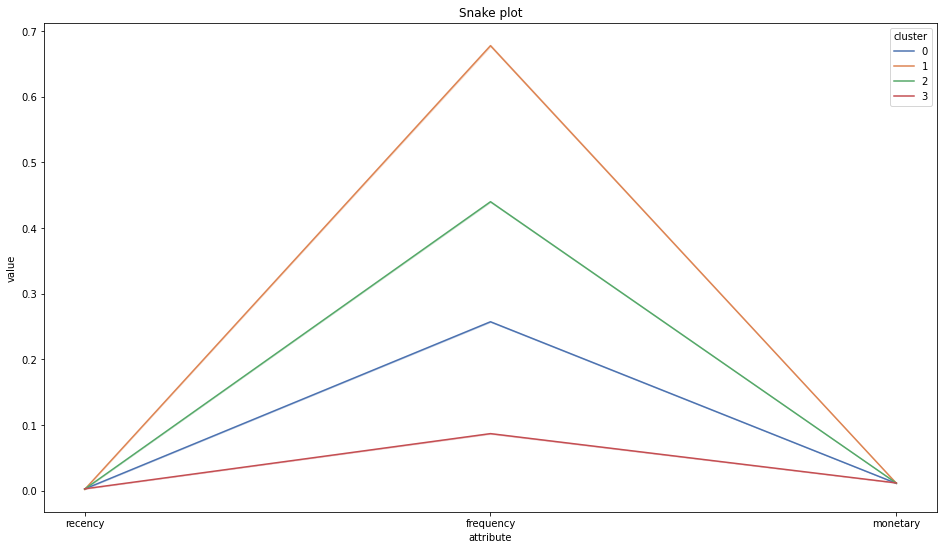

In [44]:
plt.figure(figsize=(16, 9))
plt.title('Snake plot')
sns.lineplot(x="attribute", y="value", hue='cluster', data=rfm_melt, palette='deep')

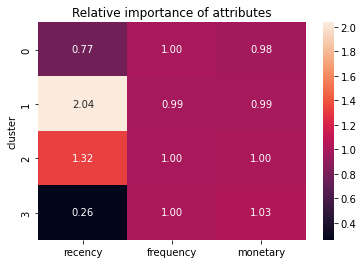

In [45]:
cluster_avg = rfm.groupby(['cluster'])[['recency', 'frequency', 'monetary']].mean()
population_avg = rfm[['recency', 'frequency', 'monetary']].mean()
relative_imp = cluster_avg / population_avg
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f')

#Conclusion

Four clusters have both monetary and recency almost same.
Frequency:
+ 0: medium
+ 1: extremely low
+ 2: high 
+ 3: relatively low

All clusters have relative importance with frequency and monetary almost same:
Recency:
+ 0: medium
+ 1: extremely low
+ 2: high
+ 3: relatively low

In conclusion, customer belong to cluster 2 seem to purchase the most times than other cluster but their last purchase was too long ago which make me to claim that they no longer interest in our platform. Cluster 0 only have a slight difference from cluster 2, so we won't focus on this cluster too. We may not decide basing on frequency because data shown that most customer only purchase once. Attract cluster 1,3 seem to make sense since their had just made a purchase recently.